# <center>Organizaci&oacute;n de Datos</center>
#### <center>C&aacute;tedra Ing. Rodriguez, Juan Manuel </center>

## <center>Ensambles</center>
### <center> Práctica Stacking y Voting</center>

## Ensemble Learning

Ensemble Learning se refiere al uso de algoritmos de ML de forma conjunta para resolver problemas de clasificación y/o regresión principalmente.

Estos algoritmos pueden ser del mismo tipo ( aprendizaje de conjunto homogéneo ) o de tipos diferentes ( aprendizaje de conjunto heterogéneo ). 

Ensemble Learning realiza una combinación estratégica de varios expertos o modelos ML con el fin de mejorar la eficacia obtenida utilizando un único modelo débil

Ensambles híbridos (combinan clasificadores de distinto tipo):

* Voting
* Stacking
* Cascading


In [ ]:
import numpy as np 
import pandas as pd
from collections import defaultdict

import matplotlib.pyplot as plt
import seaborn as sns

import plotly.graph_objects as go
%matplotlib inline

from sklearn.ensemble import RandomForestClassifier 
from sklearn.linear_model import LogisticRegression 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegressionCV

from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score



## Stacking

La idea general del método es entrenar diferentes modelos (modelos base) y un modelo más, que decide, dada una instancia nueva, qué modelo usar.
Se utiliza el concepto de meta-aprendizaje para reemplazar el mecanismo de voto.

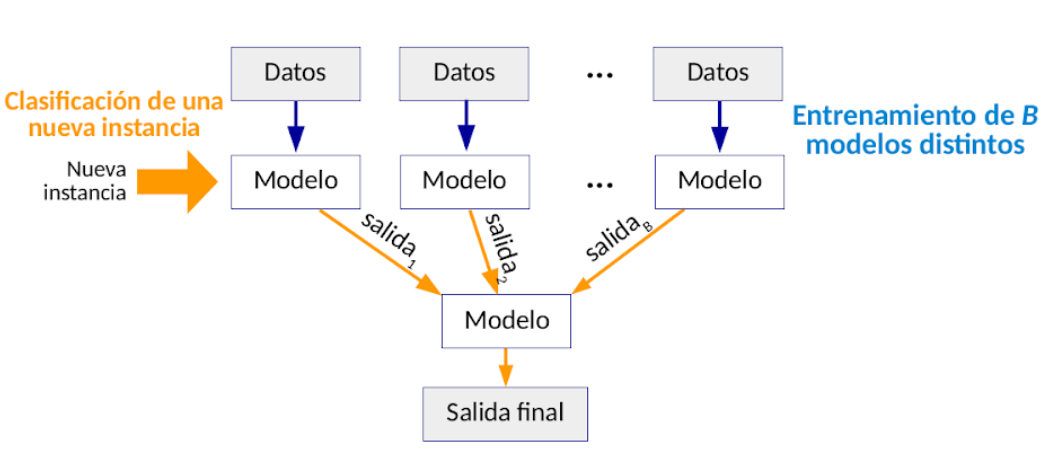

**Generación del conjunto de datos**

La función make_classification de Scikit-learn es útil para generar conjuntos de datos sintéticos que se pueden usar para probar diferentes algoritmos. El conjunto de datos que generaremos está diseñado para representar un problema de clasificación binaria basado en los siguientes parámetros:


* n_features: la cantidad de features en el conjunto de datos
* n_informative y n_redundant: la cantidad de características informativas y redundantes en el conjunto de datos.
* n_clusters_per_class: el número de clústeres incluidos en cada clase. Los valores más altos hacen que el problema sea más difícil.
* class_sep: controla la separación entre grupos/clases. Los valores más grandes facilitan la tarea.
* flip_y: especifica el porcentaje de etiquetas de clase que se asignarán al azar.Útil para agregar algo de ruido al conjunto de datos.

In [ ]:
#Creo un conjunto de datos para entrenar los modelos
x, y = make_classification(n_samples=3000, 
                           n_features=20, 
                           n_informative=15, 
                           n_redundant=5,
                           n_clusters_per_class=5,
                           class_sep=0.7,
                           flip_y=0.03,
                           n_classes=2)

In [ ]:
#Funcion para evaluar los modelos 5fold -CV (repite 2 veces)
def evaluate_model(model, x, y):
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=1)
    scores = cross_val_score(model, x, y, scoring='accuracy', cv=cv, verbose=1, n_jobs=3, error_score='raise')
    return scores

In [ ]:
#Funcion para plotear a performance
def plot_results(model_scores, name):
    
    model_names = list(model_scores.keys())
    results = [model_scores[model] for model in model_names]
    fig = go.Figure()
    for model, result in zip(model_names, results):
        fig.add_trace(go.Box(
            y=result,
            name=model,
            boxpoints='all',
            jitter=0.5,
            whiskerwidth=0.2,
            marker_size=2,
            line_width=1)
        )
    
    fig.update_layout(
    title='Performance of Different Models Using 5-Fold Cross-Validation',
    paper_bgcolor='rgb(243, 243, 243)',
    plot_bgcolor='rgb(243, 243, 243)',
    xaxis_title='Model',
    yaxis_title='Accuracy',
    showlegend=False)
    fig.show()

**Entrenamiento y evaluación de modelos individuales**

Para obtener un nivel de referencia de performance y poder compararlo con el ensamble, entrenaremos y evaluaremos individualmente los siguientes modelos base:

* Bosque aleatorio con 50 árboles de decisión (RF).
* Máquina de vectores de soporte (SVM)
* Clasificador K-vecinos más cercanos (KNN)

Cada uno de los modelos se evaluará utilizando una estrategia de validación cruzada de cinco folds repetida dos veces. En cada iteracion cada modelo se entrenó en el 80 % de los datos y se validó en el 20 % restante.

Este método da como resultado 10 puntajes de performance diferentes para cada modelo que se almacenarán en un diccionario.

In [ ]:
#Armo conjunto entrenamiento y test 80-20
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state = 42, train_size = 0.80)

In [ ]:
#Modelos Base
base_models = {'random_forest':RandomForestClassifier(n_estimators=50),
               'svm': SVC(),
               'knn': KNeighborsClassifier(n_neighbors=11)}

#Guarda los scores de cada modelo
model_scores = defaultdict()

#Entreno los clasificadores
for name, model in base_models.items():
    print('Evaluating {}'.format(name))
    scores = evaluate_model(model, x_train, y_train)
    model_scores[name] = scores

Evaluating random_forest


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    6.5s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Evaluating svm


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    1.9s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Evaluating knn


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.4s finished


In [ ]:
from sklearn.ensemble import StackingClassifier

#Modelos Base
base_models = [('random_forest', RandomForestClassifier(n_estimators=50)),
               ('svm', SVC()),
               ('knn', KNeighborsClassifier(n_neighbors=11))]

#Meta Modelo
meta_model = LogisticRegressionCV()

#Ensemble Stacking
stacking_model = StackingClassifier(estimators=base_models, 
                                    final_estimator=meta_model, 
                                    passthrough=True, 
                                    cv=5,
                                    verbose=2)

In [ ]:
#Performance el modelo en entrenamiento
stacking_scores = evaluate_model(stacking_model, x_train, y_train)
model_scores['stacking'] = stacking_scores

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:   36.6s finished


In [ ]:
#Grafico performance
plot_results(model_scores, name='stacking_model_cv')

In [ ]:
#Evaluo en conjunto de test
#stacking_model.fit(x_train,y_train).score(x_test,y_test)
stacking_model.fit(x_train,y_train)
y_pred_st = stacking_model.predict(x_test)
accuracy_score(y_test, y_pred_st)

0.8183333333333334

##  Voting

Construir N modelos utilizando los mismos datos y luego tomar la predicción mayoritaria

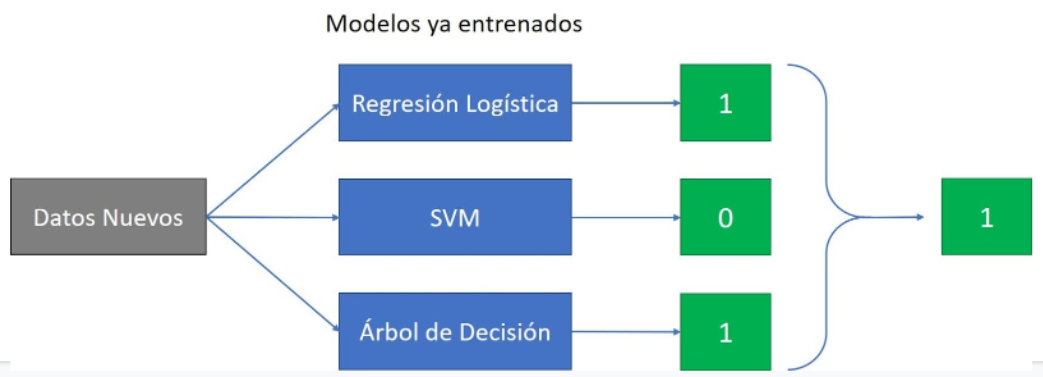

El clasificador de votaciones tiene dos hiperparámetros básicos: estimadores y votaciones. 

El hiperparámetro estimators crea una lista los clasificadores y les asigna nombres. 

El hiperparámetro de votación se establece en "hard" o "soft".

* hard: el clasificador de votación usa las etiquetas de clase predichas para la votación por regla de la mayoría. 

* soft: utilizará un enfoque ponderado para tomar su decisión (predice la etiqueta de clase en función del argmax de las sumas de las probabilidades predichas)

In [ ]:
from sklearn.ensemble import RandomForestClassifier 
from sklearn.linear_model import LogisticRegression 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [ ]:
#Creo un conjunto de datos para entrenar los modelos

x, y = make_classification(n_samples=3000, 
                           n_features=20, 
                           n_informative=15, 
                           n_redundant=5,
                           n_clusters_per_class=5,
                           class_sep=0.7,
                           flip_y=0.03,
                           n_classes=2)

In [ ]:
#Creo clasificadores

log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
knn_clf = KNeighborsClassifier()

#Creo ensemble de Votación
vot_clf = VotingClassifier(estimators = [('lr', log_clf), ('rnd', rnd_clf), ('knn', knn_clf)], voting = 'hard')

#Armo conjunto entrenamiento y test 80-20
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state = 42, train_size = 0.80)


#Entreno el ensemble
vot_clf.fit(x_train, y_train)

#Evaluo en conjunto de test
pred = vot_clf.predict(x_test)
accuracy_score(y_test, pred)

0.805